<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/ClassicalChangeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import time

In [223]:
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2013/2792_naip-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2017/2792_naip-2017.tif

--2021-01-02 06:12:41--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 597741 (584K) [application/octet-stream]
Saving to: ‘2792_nlcd-2013.tif.4’

2792_nlcd-2013.tif. 100%[===================>] 583.73K  --.-KB/s    in 0.09s   

2021-01-02 06:12:41 (6.36 MB/s) - ‘2792_nlcd-2013.tif.4’ saved [597741/597741]

--2021-01-02 06:12:41--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598432 (584K) [application/octet-st

In [224]:
naip2013 = gdal.Open("/content/2792_naip-2013.tif").ReadAsArray().transpose([1,2,0]).astype(float)
naip2017 = gdal.Open("/content/2792_naip-2017.tif").ReadAsArray().transpose([1,2,0]).astype(float)

#Normalized vegetation difference index NVDI

Good for identifying vegetation and change thereof

nvdi = (nir-red)/(nir+red)

In [225]:
np.seterr(divide='ignore', invalid='ignore')
nvdi2013 = (naip2013[:,:,3]-naip2013[:,:,0])/(naip2013[:,:,3]+naip2013[:,:,0])
nvdi2017 = (naip2017[:,:,3]-naip2017[:,:,0])/(naip2017[:,:,3]+naip2017[:,:,0])

In [226]:
def getnvdi (naip):
  nvdi =  np.divide(naip[:,:,3].astype(float)-naip[:,:,0].astype(float),naip[:,:,3]+naip[:,:,0],where = (naip[:,:,3]-naip[:,:,0])!=0)
  nvdi [nvdi==0]=-1000
  return nvdi

In [227]:
nvdi2013 = getnvdi(naip2013[-970:,-970:])
nvdi2017 = getnvdi(naip2017[-970:,-970:])

In [228]:
def plotnvdi(image, cmap="YlGn", vmin=-1,vmax=1,figsize=(15,15)):
  plt.figure(figsize=figsize)
  plot = plt.imshow(image,vmin=vmin,cmap=cmap,vmax=vmax)
  plt.colorbar(plot,fraction=0.015)
  plt.show()

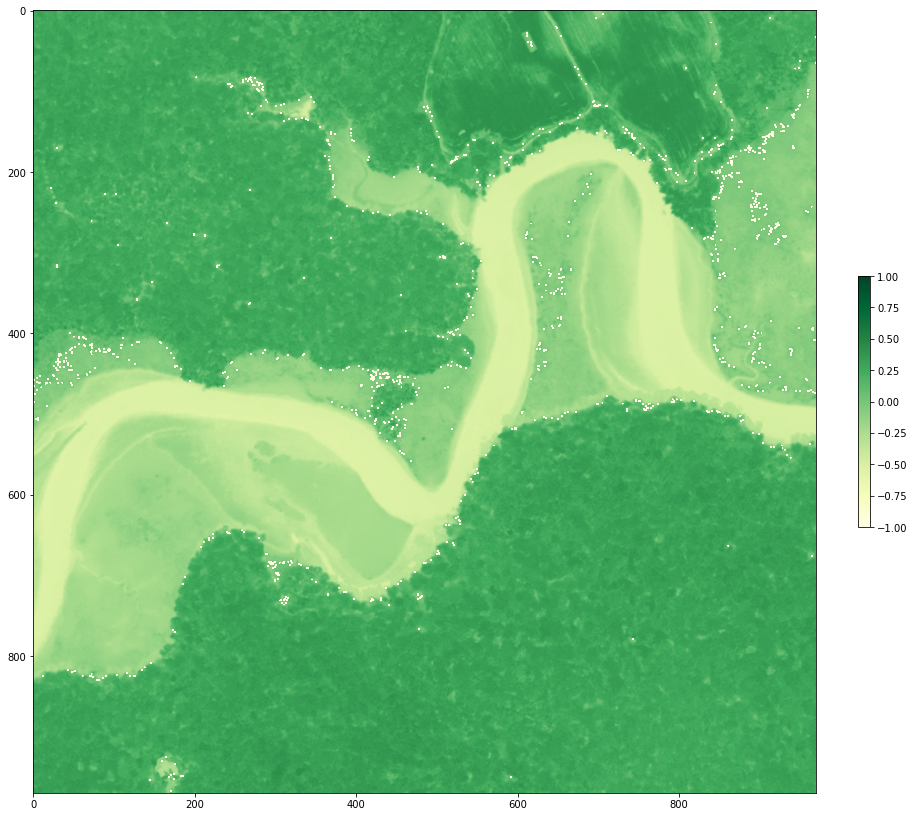

In [229]:
plotnvdi(nvdi2013)

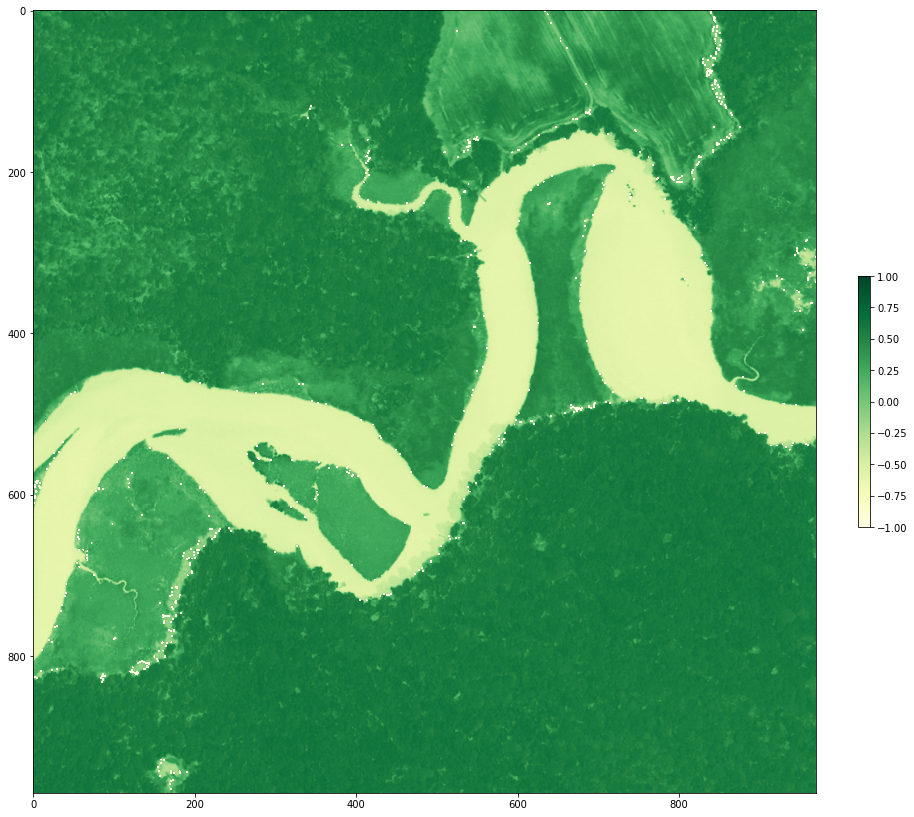

In [230]:
plotnvdi(nvdi2017)

In [231]:
nvdichange = abs(nvdi2013-nvdi2017)

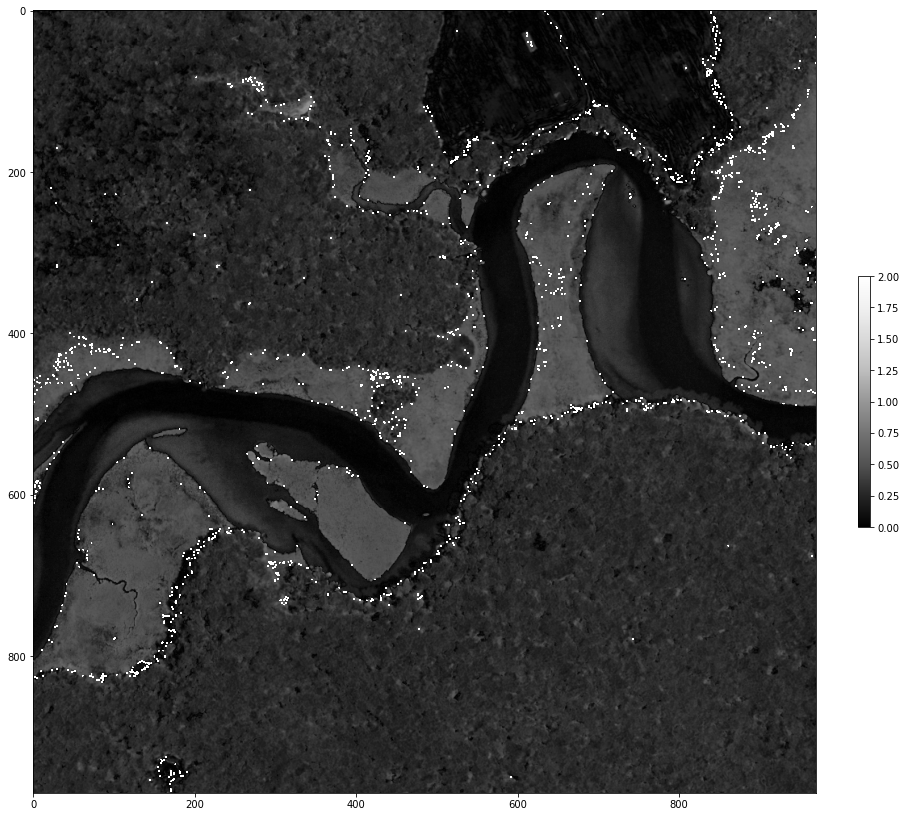

In [232]:
plotnvdi(nvdichange,cmap="Greys_r",vmin=0,vmax=2)

#Principal component analysis PCA

do it for each band

In [233]:
from sklearn.decomposition import PCA

In [234]:
imgdiff = np.abs(naip2017-naip2013)[-970:,-970:,:]

##tile the image

In [235]:
def img_to_flat_tiles(image,tilesize=(5,5)):
  """returns a list of tiles flattened into 1d arrays from a single band image, normalized by its mean"""
  #I can probably write a vectorized version for speed
  (M,N) = image.shape
  (m,n) = tilesize
  tiles = [image[x:x+m,y:y+n].ravel() for x in range(0,M,m) for y in range(0,N,n)]
  mean = np.mean(tiles,axis=0)
  return (tiles-mean), mean

In [236]:
band3tiles, band3mean = img_to_flat_tiles(imgdiff[:,:,3])

##calculate principal components of tiles

In [237]:
pca = PCA()
pca.fit(band3tiles)
EigenvecMatrix = pca.components_

##create feature vectors (5x5 flattened) at each pixels
should really pad the image here

In [238]:
def img_to_feature_tiles(image,tilesize = (5,5)):
  """returns a list of tiles flattened into 1d arrays from a single band image, normalized by its mean, mapped to PCA-eigenvector coordinates"""
  #I can probably write a vectorized version for speed
  (M,N) = image.shape
  tiles = [np.dot(image[x-2:x+3,y-2:y+3].ravel(),EigenvecMatrix) for x in range(2,M-2) for y in range(2,N-2)]
  mean = np.dot(np.mean(tiles,axis=0),EigenvecMatrix)
  return (tiles-mean), mean

In [239]:
def img_to_feature_tiles(image, tilesize = (5,5)):
  """returns a list of tiles flattened into 1d arrays from a multi-band image, normalized by its mean, mapped to PCA-eigenvector coordinates"""
  #I can probably write a vectorized version for speed
  M = image.shape[0]
  N = image.shape[1]
  (m,n) = (tilesize[0]//2,tilesize[1]//2)
  tiles = [np.dot(EigenvecMatrix.T,image[x-m:x+m+1,y-n:y+n+1].reshape((tilesize[0]*tilesize[1],-1))) for x in range(m,M-m) for y in range(m,N-m)]
  mean = np.dot(EigenvecMatrix.T,np.mean(tiles,axis=0))
  return (tiles-mean), mean

In [240]:
pad=2
paddeddiff  = np.pad(imgdiff,[(pad,pad),(pad,pad),(0,0)])
np.shape(paddeddiff)

(974, 974, 4)

In [241]:
t1 = time.time()
band3features,meanfeature = img_to_feature_tiles(paddeddiff[:,:,3])
print(time.time()-t1)

5.18799090385437


In [242]:
band3features.shape

(940900, 25, 1)

In [243]:
np.shape(band3features)

(940900, 25, 1)

In [244]:
from sklearn.cluster import KMeans
from collections import Counter

##use kmeans to cluster changed and unchanged pixels

In [245]:
def clustermap(features, K=3,imgsize=(970+4,970+4)):
  #apparently 3 clusters works better than 2
  #least index is the cluster that appears least often, corresponding to change cluster
  kmeans = KMeans(K, verbose = 0)
  kmeans.fit(features)
  pred = kmeans.predict(features)
  count = Counter(pred)
  least_index = min(count, key = count.get)
  change_map = np.reshape(pred,(imgsize[0] - 4, imgsize[1] - 4))
  return least_index, change_map


In [253]:
t1 = time.time()
index, map = clustermap(band3features[:,:,0])
map[map==index]=1
map[map!=1]=0
print (time.time()-t1)

17.661248445510864


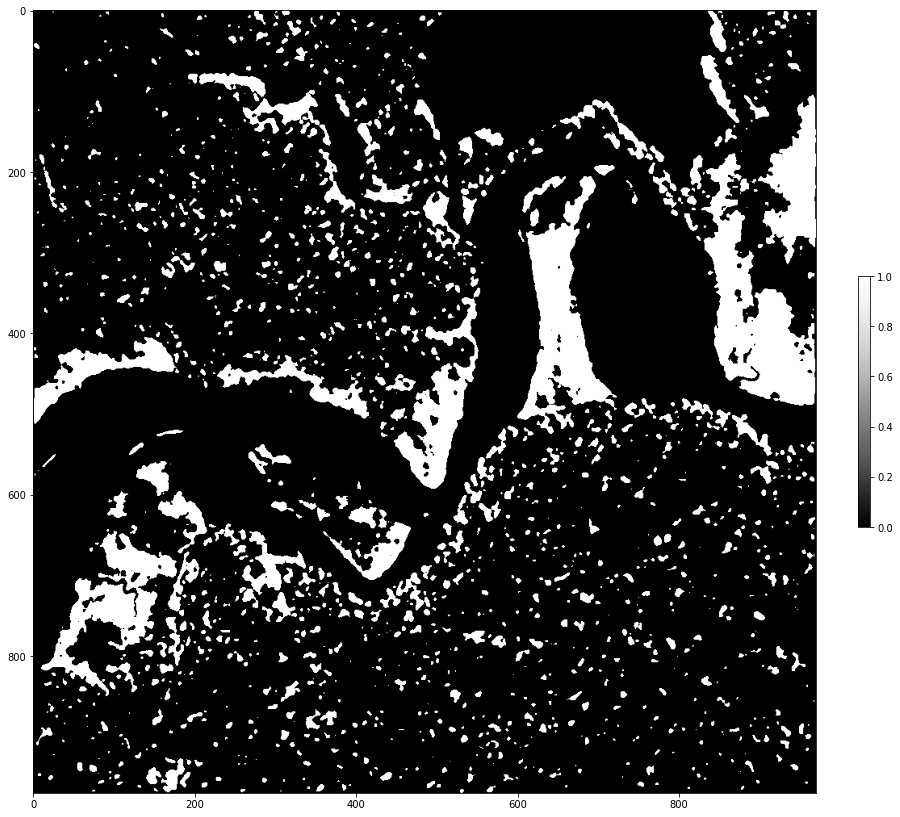

In [254]:
plotnvdi(map,cmap="Greys_r",vmax=1,vmin=0)

In [248]:
def pca_change_detection(image, tilesize = (5,5), band = 3 , K = 2):

  image = image[:,:,band] #single band image (W,H)
  tiles, _ = img_to_flat_tiles(image, tilesize=tilesize)
  pca = PCA()
  pca.fit(tiles)
  EigenvecMatrix = pca.components_
  Xpad = tilesize[0]//2
  Ypad = tilesize[1]//2

  paddeddiff  = np.pad(image,[(Xpad,Xpad),(Ypad,Ypad)])
  tiles,_ = img_to_feature_tiles(paddeddiff, tilesize = tilesize)
  #tiles is of shape (nfeatures, featuresize, 1)
  index, map = clustermap(tiles[:,:,0], K = K , imgsize = paddeddiff.shape)
  map[map==index]=1
  map[map!=1]=0
  return map

In [249]:
map2 = pca_change_detection(imgdiff, band = 3)

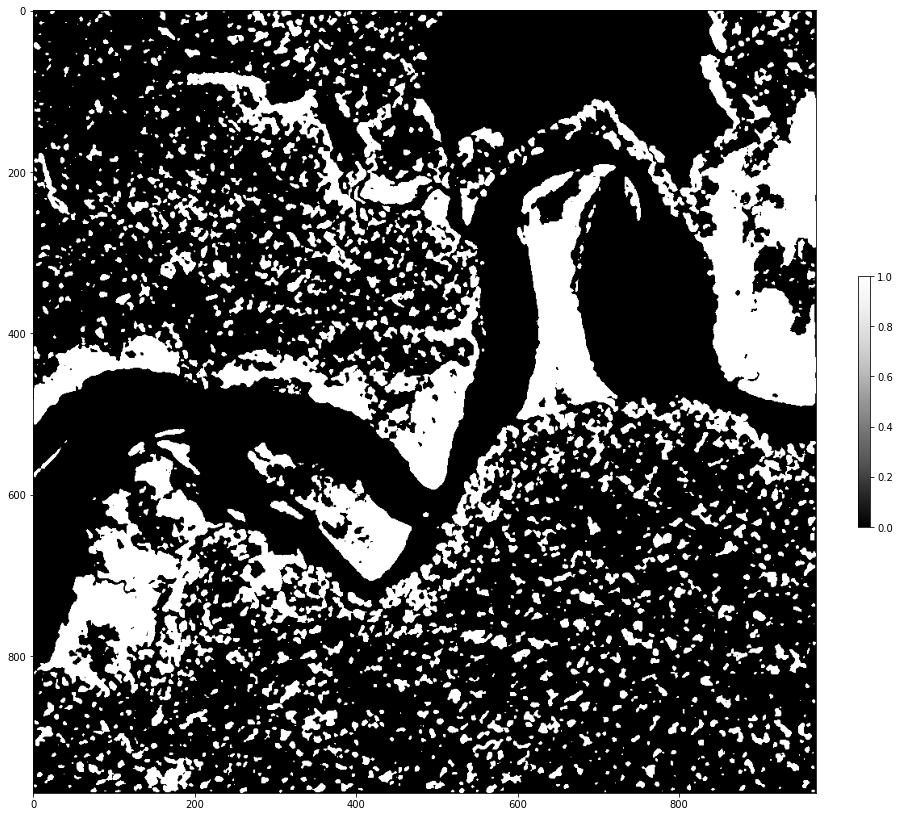

In [250]:
plotnvdi(map2,cmap="Greys_r",vmax=1,vmin=0)

##Crashes from running out of memory on collab

In [251]:
"""

xslices = 4
yslices = 4
subimagessize = (970,970)
image =  np.abs(naip2017-naip2013)[:,:,-1].astype(np.float16)

featuresize = (5,5)


padx = featuresize[0]//2
pady = featuresize[1]//2
paddeddimg  = np.pad(image,[(padx,padx),(pady,pady)]).astype(np.float16)
pca = PCA()
pca_image = np.zeros(image.shape).astype(np.float16)

for x in range(xslices):

  for y in range(yslices):

    subimage = image[subimagessize[0]*x:subimagessize[0]*(x+1),subimagessize[1]*y:subimagessize[1]*(y+1)]
    tiles, _ = img_to_flat_tiles(subimage,tilesize = featuresize)
    tiles.astype(np.float16)
    EigenvecMatrix = np.zeros((featuresize[0]*featuresize[1],featuresize[0]*featuresize[1],image.shape[-1]))
    
    pca.fit(tiles)
    EigenvecMatrix = pca.components_
    
    features =  img_to_feature_tiles(paddeddimg[:,:], tilesize = featuresize).astype(np.float16)
    index, map = clustermap(features[:,:,0])
    map[map==index]=1
    map[map!=1]=0

    pca_image[subimagessize[0]*x:subimagessize[0]*(x+1),subimagessize[1]*y:subimagessize[1]*(y+1),i] = map"""

'\n\nxslices = 4\nyslices = 4\nsubimagessize = (970,970)\nimage =  np.abs(naip2017-naip2013)[:,:,-1].astype(np.float16)\n\nfeaturesize = (5,5)\n\n\npadx = featuresize[0]//2\npady = featuresize[1]//2\npaddeddimg  = np.pad(image,[(padx,padx),(pady,pady)]).astype(np.float16)\npca = PCA()\npca_image = np.zeros(image.shape).astype(np.float16)\n\nfor x in range(xslices):\n\n  for y in range(yslices):\n\n    subimage = image[subimagessize[0]*x:subimagessize[0]*(x+1),subimagessize[1]*y:subimagessize[1]*(y+1)]\n    tiles, _ = img_to_flat_tiles(subimage,tilesize = featuresize)\n    tiles.astype(np.float16)\n    EigenvecMatrix = np.zeros((featuresize[0]*featuresize[1],featuresize[0]*featuresize[1],image.shape[-1]))\n    \n    pca.fit(tiles)\n    EigenvecMatrix = pca.components_\n    \n    features =  img_to_feature_tiles(paddeddimg[:,:], tilesize = featuresize).astype(np.float16)\n    index, map = clustermap(features[:,:,0])\n    map[map==index]=1\n    map[map!=1]=0\n\n    pca_image[subimagessize

##iterative regularized multivariate alteration detection IRMAD  
from https://github.com/Bobholamovic/ChangeDetectionToolbox matlab code


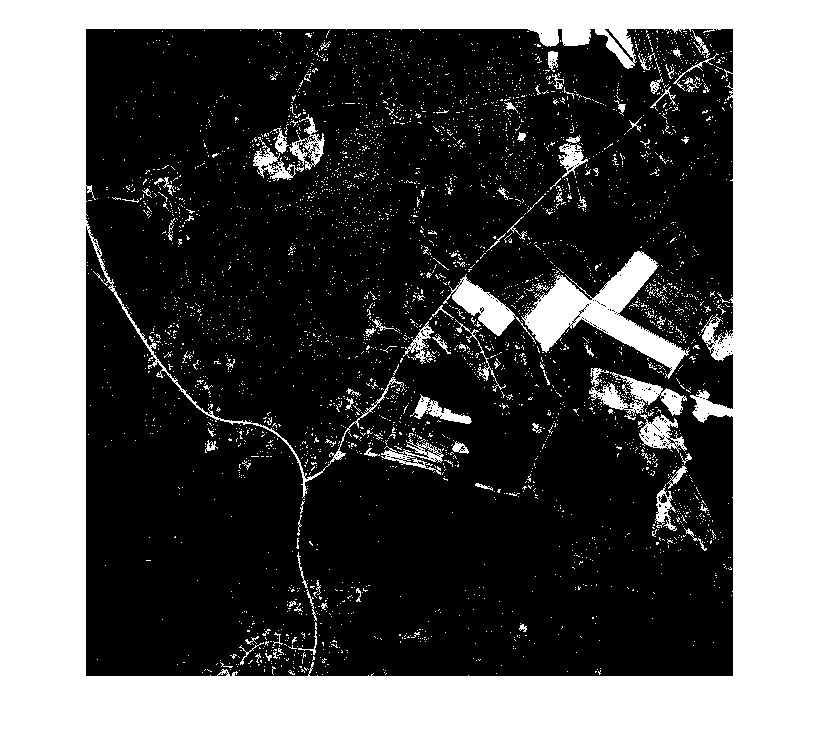

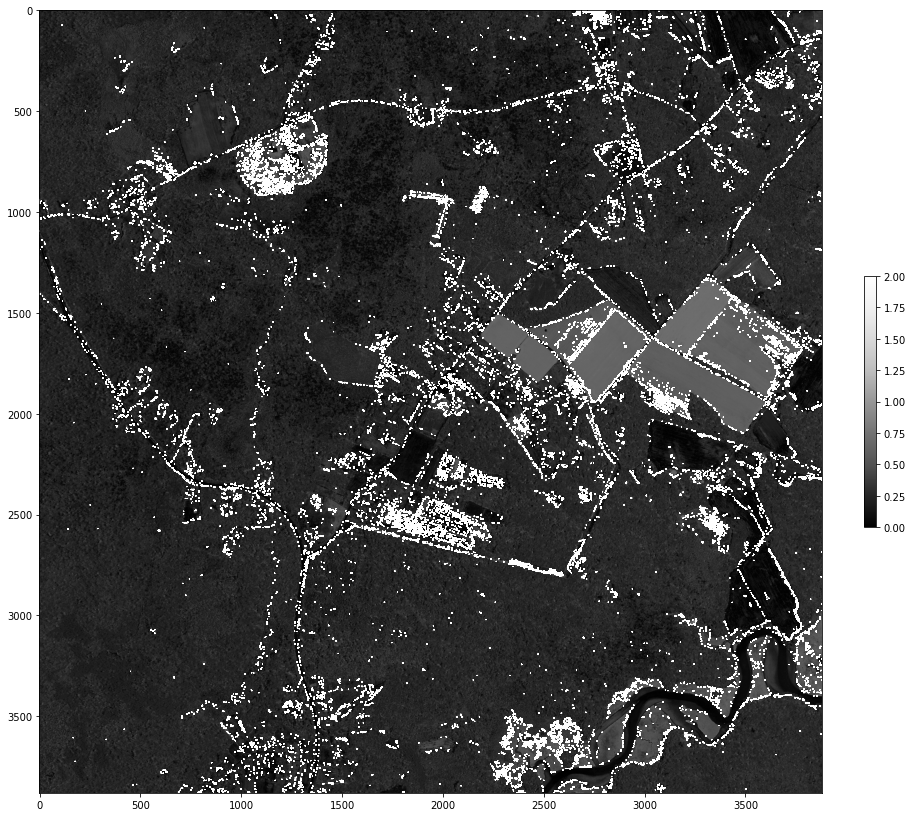

In [252]:
nvdi2013 = getnvdi(naip2013)
nvdi2017 = getnvdi(naip2017)
nvdichange = abs(nvdi2013-nvdi2017)
plotnvdi(nvdichange,cmap="Greys_r",vmin=0,vmax=2)